# Analyse du modèle de canalisation

Dans ce notebook, on présente le modèle de canalisation qui sera utilisé pour constituer un réseau de chaleur. 

Ce modèle permet de calculer la température de l'eau en sortie d'une canalisation connaissant la température de l'eau en entrée et le débit (en kg/s) qui circule dans la canalisation. Les paramètres du modèle sont :
- la longueur de la canalisation (en mètre),
- la conductivité thermique de l'isolant (en W/(m.K), 
- le débit nominal de la canalisation (en kg/s).

Ce modèle de type "Plug-flow" discrétise la canalisation en un grand nombre de petits tronçons de température uniforme et exploite une approche lagrangienne pour décrire l'évolution du fluide dans chacun de ces éléments lors de leur circulation dans la canalisation. Cela permet de calculer les pertes de chaleur à travers la canalisation et l'évolution de la température du fluide dans chacun des tronçons.

Dans ce qui suit, on propose simplement de découvrir le code et d'observer les sorties du modèle pour différents paramétrage.


## Présentation du modèle "Plug-Flow"

In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

dossier = os.getcwd()

**Paramètres**

In [2]:
temps_simu = 72 #temps en heures
pas_de_temps = 10 # pas de temps des entrées et sorties en minutes
nb_pdt = int(temps_simu*60/pas_de_temps)

**Constantes physiques**

In [3]:
Rho = 1000 # kg/m3
Cp = 4180 # J/(kg.K)
Nu = 0.000001 #Viscosité de l'eau

**Caractéristiques connues de la canalisation**

In [4]:
Long = 2000 # longueur en mètres
Lambda_iso = 0.02 #conductivité thermique de l'isolan
V_lim = 2 # m/s #Vitesse maximale du fluide dans la canalisation (sert à dimensionner le diamètre de la canalisation)
Mtub_nom = 10  # kg/s       "Débit nominal

**Entrées de la simulation**

In [5]:
"Débit en entrée"
#option 1 : débit constant
Mtub = np.ones(nb_pdt)*Mtub_nom*0.8

"Température de l'eau en entrée"
#Evolution sinusoïdale de la température
Tin = [50+5*math.sin(math.pi*t*10/(12*60)/2) for t in range(nb_pdt)]

"Température de sol"
Tsol = 10  #Température du sol (supposée constante)

**Détermination des caractéristiques nominales**

In [6]:
D_tube = np.round( (4 * Mtub_nom / (Rho * V_lim *math.pi))**(0.5), 2) # Calcul du diamètre des canalisation (m)
e_iso = 30.77 * D_tube**3 - 11.43 * D_tube**2 + 1.45 * D_tube #Calcul de l'épaisseur d'isolant

**Paramètres du schéma numérique**

In [7]:
delta_t = 1 # pas de temps de calcul en minutes
N=int(Long/10)      #Nombre initial de volumes dans le tuyau
nb_dt = int(pas_de_temps/delta_t)
dt = 60*delta_t        #conversation pas de temps de calcul en secondes

**Initialisation du maillage du tuyau**

In [8]:
Tout = np.zeros(nb_pdt)
Nout = np.zeros(nb_pdt)
L_vol = np.ones(N)*Long/N                                                          # longueur de chaque volume 
T_vol=np.ones(N)*50                                                                # Température de chaque volume
M_vol=np.ones(N)*Rho*Cp*math.pi * D_tube**2 / 4 * L_vol                            # Masse thermique de chaque volume 
R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)   # Résistance thermique de chaque volume

Tout[0] = T_vol[-1]
Nout[0] = N

**Calcul de la température en sortie**

In [9]:
for t in range(nb_pdt-1):
    if Mtub[t]==0:
        Mtub[t]=0.0001
        
    for k in range(nb_dt):
        M_0 = np.array([Cp*Mtub[t]*dt])
        T_0 = np.array([Tin[t]])
        L_0 = np.array([Mtub[t]*dt/(Rho*math.pi*(D_tube/2)**2)])            

        T_vol2 = np.concatenate((T_0,T_vol*(1-dt/(R_vol*M_vol)) + dt/(R_vol*M_vol)*Tsol))
        L_vol2 = np.concatenate((L_0,L_vol))
        M_vol2 = np.concatenate((M_0,M_vol))

        L_vol3 = np.concatenate((L_vol2[np.cumsum(L_vol2)<Long],np.array([Long-np.sum(L_vol2[np.cumsum(L_vol2)<Long])])))
        T_vol3 = np.resize(T_vol2,np.shape(L_vol3))
        M_vol3 = Rho*Cp*math.pi * D_tube**2 / 4 *L_vol3
        M_vol22 = np.copy(M_vol3)
        M_vol22.resize(np.shape(M_vol2),refcheck=False)

        T_vol = T_vol3
        L_vol = L_vol3
        M_vol = M_vol3
        R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)
    
    Tout[t+1] = np.sum((M_vol2-M_vol22)*T_vol2)/np.sum(M_vol2-M_vol22)
    Nout[t+1] = np.shape(T_vol)[0]

**Sorties graphiques**

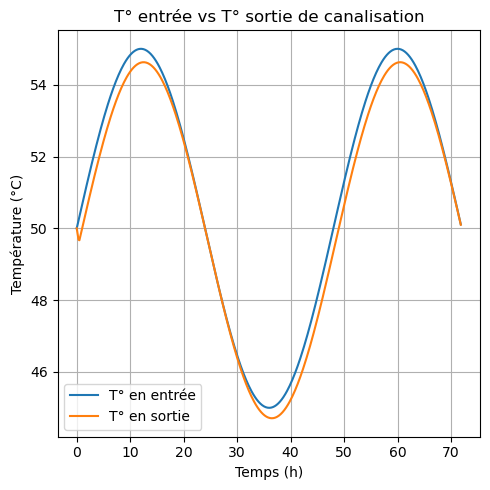

In [10]:
fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tin,label = 'T° en entrée')
axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tout, label = 'T° en sortie')
axes.legend()
axes.set(xlabel='Temps (h)', ylabel='Température (°C)',
       title='T° entrée vs T° sortie de canalisation')
axes.grid()

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
os.chdir(dossier+'\\Outputs')
fig1.savefig("test_tuyau.png")
os.chdir(dossier)
plt.show()

## Analyse du modèle

*<ins>Travail demandé</ins>: mettre en évidence les paramètres d'influence du retard en sortie de canalisation et des pertes thermiques. Pour cela, vous êtes invités à modifier les différents paramètres caractérisant la canalisation (longueur, débit nominal) et les données d'entrées (débit circulant dans la canalisation, température du sol).*


Pour plus de praticité, utiliser le code ci-dessous. **Penser à renommer les sorties graphiques** (anté-pénultième ligne du code ci-dessous)

**Paramètres et données d'entrée**

In [11]:
"Caractéristiques du tube"
Long = 2000 # longueur en mètres
Lambda_iso = 0.02 #conductivité thermique de l'isolan
V_lim = 2 # m/s #Vitesse maximale du fluide dans la canalisation (sert à dimensionner le diamètre de la canalisation)
Mtub_nom = 10  # kg/s       "Débit nominal

"Débit en entrée"
Mtub = np.ones(nb_pdt)*Mtub_nom*0.8

"Température de l'eau en entrée"
Tin = [50+5*math.sin(math.pi*t*10/(12*60)/2) for t in range(nb_pdt)]

"Température de sol"
Tsol = 10  #Température du sol (supposée constante)

**Simulation (ne pas modifier)**

In [12]:

"Simulation"
D_tube = np.round( (4 * Mtub_nom / (Rho * V_lim *math.pi))**(0.5), 2) # Calcul du diamètre des canalisation (m)
e_iso = 30.77 * D_tube**3 - 11.43 * D_tube**2 + 1.45 * D_tube #Calcul de l'épaisseur d'isolant

delta_t = 1 # pas de temps de calcul en minutes
N=int(Long/10)      #Nombre initial de volumes dans le tuyau
nb_dt = int(pas_de_temps/delta_t)
dt = 60*delta_t        #conversation pas de temps de calcul en secondes

Tout = np.zeros(nb_pdt)
Nout = np.zeros(nb_pdt)
L_vol = np.ones(N)*Long/N                                                          # longueur de chaque volume 
T_vol=np.ones(N)*50                                                                # Température de chaque volume
M_vol=np.ones(N)*Rho*Cp*math.pi * D_tube**2 / 4 * L_vol                            # Masse thermique de chaque volume 
R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)   # Résistance thermique de chaque volume

Tout[0] = T_vol[-1]
Nout[0] = N

for t in range(nb_pdt-1):
    if Mtub[t]==0:
        Mtub[t]=0.0001
        
    for k in range(nb_dt):
        M_0 = np.array([Cp*Mtub[t]*dt])
        T_0 = np.array([Tin[t]])
        L_0 = np.array([Mtub[t]*dt/(Rho*math.pi*(D_tube/2)**2)])            

        T_vol2 = np.concatenate((T_0,T_vol*(1-dt/(R_vol*M_vol)) + dt/(R_vol*M_vol)*Tsol))
        L_vol2 = np.concatenate((L_0,L_vol))
        M_vol2 = np.concatenate((M_0,M_vol))

        L_vol3 = np.concatenate((L_vol2[np.cumsum(L_vol2)<Long],np.array([Long-np.sum(L_vol2[np.cumsum(L_vol2)<Long])])))
        T_vol3 = np.resize(T_vol2,np.shape(L_vol3))
        M_vol3 = Rho*Cp*math.pi * D_tube**2 / 4 *L_vol3
        M_vol22 = np.copy(M_vol3)
        M_vol22.resize(np.shape(M_vol2),refcheck=False)

        T_vol = T_vol3
        L_vol = L_vol3
        M_vol = M_vol3
        R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)
    
    Tout[t+1] = np.sum((M_vol2-M_vol22)*T_vol2)/np.sum(M_vol2-M_vol22)
    Nout[t+1] = np.shape(T_vol)[0]


**Sorties graphiques**

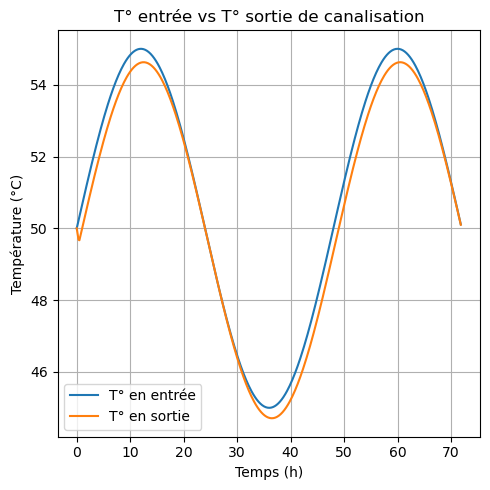

In [13]:
fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tin,label = 'T° en entrée')
axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tout, label = 'T° en sortie')
axes.legend()
axes.set(xlabel='Temps (h)', ylabel='Température (°C)',
       title='T° entrée vs T° sortie de canalisation')
axes.grid()

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
os.chdir(dossier+'\\Outputs')
fig1.savefig("test_tuyau_2.png")
os.chdir(dossier)
plt.show()